In [1]:
import matplotlib.pyplot as plt
import numpy as np
import unittest
%matplotlib inline

In [2]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [3]:
def get_gray_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [4]:
def crop_img(img, keep_below=350):
    return img[keep_below:,:]

In [5]:
import glob
def get_vehicles():
    return glob.glob('./vehicles/**/*.png')

def get_non_vehicles():
    return glob.glob('./non-vehicles/**/*.png')


/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


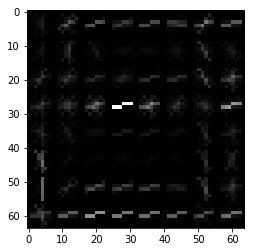

In [6]:
import cv2
gray = get_gray_img('./vehicles/GTI_MiddleClose/image0000.png')
features, hog_image = get_hog_features(gray, 9, 8, 2, vis=True)
plt.imshow(hog_image, cmap='gray')

# of vehicles: 8792
# of non-vehicles: 8968


/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


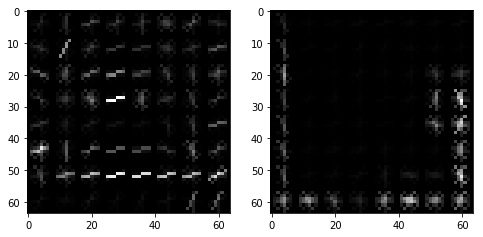

In [7]:
vehicles = get_vehicles()
non_vehicles = get_non_vehicles()

gray_vehicle = get_gray_img(vehicles[0])
vehicle_features, vehicle_hog_image = get_hog_features(gray_vehicle, 9, 8, 2, vis=True)

gray_non_vehicle = get_gray_img(non_vehicles[0])
non_vehicle_features, non_vehicle_hog_image = get_hog_features(gray_non_vehicle, 9, 8, 2, vis=True)

print('# of vehicles: %d' % len(vehicles))
print('# of non-vehicles: %d' % len(non_vehicles))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = ax.ravel()
ax[0].imshow(vehicle_hog_image, cmap='gray')
ax[1].imshow(non_vehicle_hog_image, cmap='gray')

In [8]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#### Make sure extract_features is working as expected.

In [9]:
vehicles = [get_vehicles()[0]]
extracted_features = extract_features(vehicles)
img = cv2.cvtColor(cv2.imread(vehicles[0]), cv2.COLOR_BGR2RGB)
hog_features = [get_hog_features(img[:,:,0], 9, 8, 2)]
np.testing.assert_array_equal(extracted_features, hog_features)

/Users/kevinwestern/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Now let's load the cars and non cars data

In [335]:
car_features = extract_features(get_vehicles(), cspace='YUV', hog_channel='ALL')
non_car_features = extract_features(get_non_vehicles(), cspace='YUV', hog_channel='ALL')

#### And create our features and labels

In [336]:
from sklearn.preprocessing import StandardScaler

# Create rows of features
# np.vstack([1,2], [3,4]) ->
# [[1,2],
#  [3,4]]
X = np.vstack((car_features, non_car_features)).astype(np.float64)
# Don't scale since we're not combining features
#X_scaler = StandardScaler().fit(X)
#scaled_X = X_scaler.transform(X)

# Create labels
# np.hstack([1,2],[3,4]) ->
# [1,2,3,4]
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

#### And split it up

In [337]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True)

#### Now build a model since we have training and test data.

In [338]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print('Accuracy of %f' % accuracy)

Accuracy of 0.987331


In [188]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), debug=False):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    if debug:
        print('xspan: %f' % xspan)
        print('yspan: %f' % yspan)
        print('nx_pix_per_step: %f' % nx_pix_per_step)
        print('ny_pix_per_step: %f' % ny_pix_per_step)
        print('nx_buffer: %f' % nx_buffer)
        print('ny_buffer: %f' % ny_buffer)
        print('nx_windows: %f' % nx_windows)
        print('ny_windows: %f' % ny_windows)
    return window_list


In [186]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [167]:
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[400:656,:,:]
windows = slide_window(img)

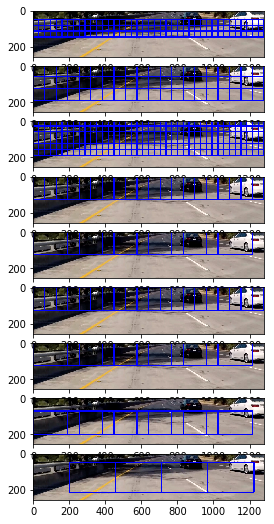

In [272]:
all_windows = [
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(50, 150)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 200),
        xy_window=(128, 128)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 200),
        xy_window=(128, 128),
        xy_overlap=(0.75, 0.75),
        debug=False),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.75, 0.75)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.75, 0.75)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(0, 150),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(0, img.shape[1]),
        y_start_stop=(75, img.shape[0]),
        xy_window=(256, 128),
        xy_overlap=(0.25, 0.25)),
    slide_window(
        img,
        x_start_stop=(200, 1400),
        y_start_stop=(50, img.shape[0]),
        xy_window=(256, 164),
        xy_overlap=(0.0, 0.0))
]

fig, ax = plt.subplots(nrows=len(all_windows), ncols=1, figsize=(16, 9))
ax = ax.ravel()
for i in range(len(all_windows)):
    ax[i].imshow(draw_boxes(img, all_windows[i]))


## Extract features from a single image. This will be used in addition to the sliding window.

In [350]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#### Look through a list of windows and return the ones we think have cars.

In [352]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

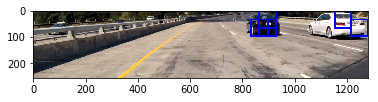

In [353]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[400:656,:,:]
windows = slide_window(img)
matches = search_windows(img, windows, svc, X_scaler, color_space='YUV', hog_channel='ALL', spatial_feat=False, hist_feat=False)
plt.imshow(draw_boxes(img, matches))

#### Instead of searching window, let's try subsampling in one pass.

In [354]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    matches = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            test_prediction = svc.predict(np.array(hog_features).reshape(1, -1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                matches.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return matches

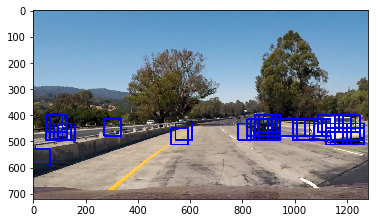

In [355]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

matches = find_cars(img, 400, 656, 1, svc, X_scaler, 9, 8, 2, None, None)
plt.imshow(draw_boxes(img, matches))

In [356]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [357]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

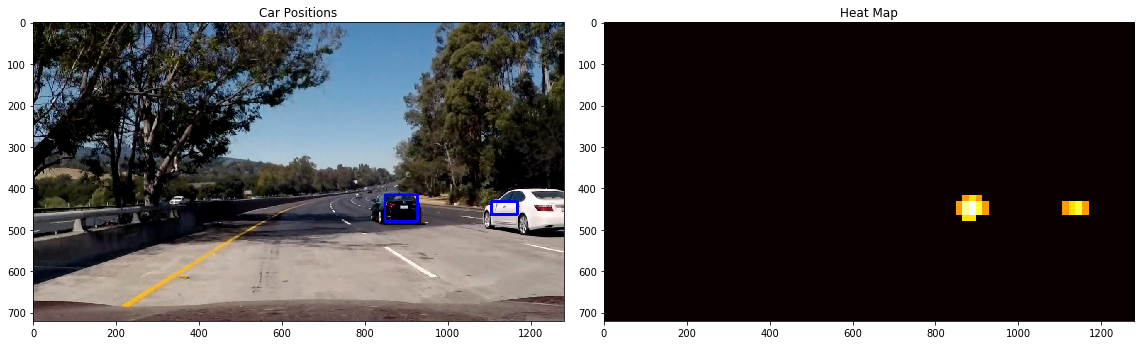

In [359]:
from scipy.ndimage.measurements import label
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

matches = find_cars(img, 400, 656, 1, svc, X_scaler, 9, 8, 2, None, None)
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, matches)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [256]:
from moviepy.editor import VideoFileClip

test_windows = []
for windows in all_windows:
        for window in windows:
            test_windows.append(window)

def process_image(img):
    cropped_img = img[400:656,:,:]

    matches = search_windows(cropped_img, test_windows, svc, X_scaler, spatial_feat=False, hist_feat=False)
    heat = np.zeros_like(cropped_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, matches)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(cropped_img), labels)
    result = np.copy(img)
    result[400:656,:,:] = draw_img
    return result

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('test_video.mp4')
video = video_input.fl_image(process_image)
video.write_videofile(video_output)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 34/34 [00:00<00:00, 572.23it/s]

[MoviePy] Done.
[MoviePy] Writing video project_video_output.mp4



 97%|█████████▋| 38/39 [00:14<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

